# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

from einops import rearrange, repeat
from transformers import AutoTokenizer

from MAMBA import SkipConnect

c:\Users\trail\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data import and Pre-Process

In [2]:
df = pd.read_csv("dataset/youtube_dataset_balanced.csv")
df = df.sample(frac=1).reset_index(drop=True)

texts = df['title']
labels = df['Category']

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size
tokenized_texts = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=36, return_tensors="np")

input_ids = tokenized_texts['input_ids']
labels = np.array(labels)

x_train, x_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.2, random_state=42)

BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).shuffle(1000)

# Initialize model

In [3]:
def init_model(seq_length,vocab_size,model_input_dims,model_states,num_layers,dropout_rate,num_classes,final_activation):
    input_layer = layers.Input(shape=(seq_length,), name='input_ids')
    x = layers.Embedding(
                vocab_size,
                model_input_dims,
                input_length=seq_length)(input_layer)

    for i in range(num_layers):
        x = SkipConnect(model_input_dims,model_states)(x)
        x = layers.Dropout(dropout_rate)(x) # for regularization

    x = layers.LayerNormalization(epsilon=1e-5)(x) # normalization layer
    x = layers.Flatten()(x)  # Flatten before dense layers
    x = layers.Dense(1024, activation=tf.nn.gelu)(x)
    output_layer = layers.Dense(num_classes, activation=final_activation)(x)

    model = Model(
                inputs=input_layer,
                outputs=output_layer, name='MAMBA')
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.AdamW(),
        metrics=['accuracy']
    )

    return model

In [6]:
seq_length = 36
model = init_model(seq_length = seq_length, vocab_size=vocab_size, model_input_dims= 16,model_states = 4,num_layers=2, dropout_rate=0.2, num_classes=1, final_activation='sigmoid')

early_stopping = EarlyStopping(
    monitor='accuracy',  # Monitor the accuracy metric
    patience=3,          # Stop training if accuracy does not improve for 3 consecutive epochs
    restore_best_weights=True,  # Restore the model weights from the epoch with the best value of the monitored quantity
    verbose = 1 # Display a message if early stopping is triggered
)

model.summary()

Model: "MAMBA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 36)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 36, 16)            488352    
                                                                 
 skip_connect_2 (SkipConnect  (None, 36, 16)           2240      
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 36, 16)            0         
                                                                 
 skip_connect_3 (SkipConnect  (None, 36, 16)           2240      
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 36, 16)            0     

In [7]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])

Epoch 1/30
75/75 [==============================] - 10s 83ms/step - loss: 0.7292 - accuracy: 0.6010 - val_loss: 0.5471 - val_accuracy: 0.7256
Epoch 2/30
75/75 [==============================] - 5s 69ms/step - loss: 0.3007 - accuracy: 0.8775 - val_loss: 0.4106 - val_accuracy: 0.8316
Epoch 3/30
75/75 [==============================] - 5s 72ms/step - loss: 0.0835 - accuracy: 0.9722 - val_loss: 0.4977 - val_accuracy: 0.8519
Epoch 4/30
75/75 [==============================] - 5s 70ms/step - loss: 0.0345 - accuracy: 0.9899 - val_loss: 0.5659 - val_accuracy: 0.8485
Epoch 5/30
75/75 [==============================] - 5s 72ms/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.6338 - val_accuracy: 0.8535
Epoch 6/30
75/75 [==============================] - 5s 72ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 0.6487 - val_accuracy: 0.8670
Epoch 7/30
75/75 [==============================] - 6s 76ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.6303 - val_accuracy: 0.8687
Epoch 8/30
7

In [9]:
def make_prediction(text):
  input_text = [text]
  tokenized_texts = tokenizer(input_text, padding='max_length', truncation=True, max_length=36, return_tensors="tf")

  # Perform inference
  predictions = model.predict(tokenized_texts['input_ids'])

  if predictions[0][0] >= 0.5:
    print(f"Predicted class: Educational with confidence: {predictions[0][0] * 100}%")

  else:
    print(f"Predicted class: Non-Educational with confidence: {(1 - predictions[0][0]) * 100}%")

In [10]:
make_prediction("Fundamental of wavefunctions and their applications in chemistry")

1/1 [==============================] - 1s 542ms/step
Predicted class: Educational with confidence: 99.9998927116394%


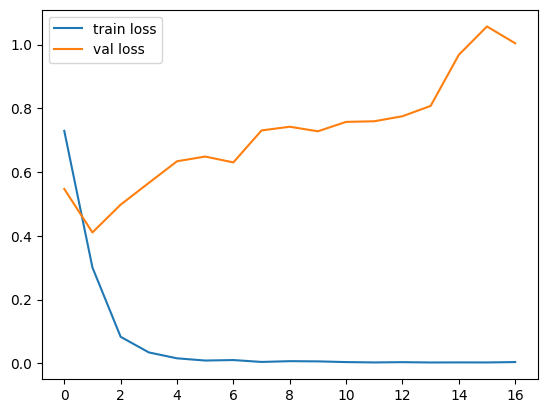

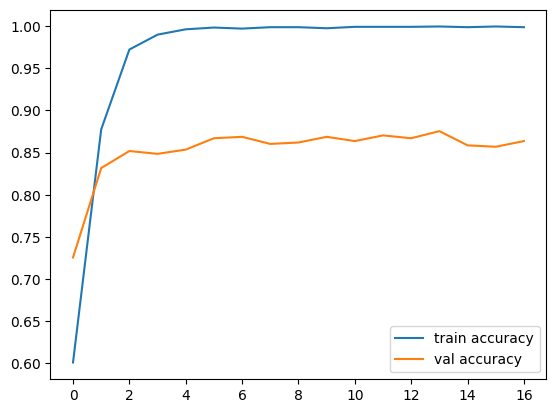

In [11]:
# plot loss and accuracy curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('MAMBA_model')